### Inits

In [1]:
import sys
sys.path.append("..")

In [11]:
from balls import *


import mpmath
# import pylab
from pylab import *

#Matplotlib defs
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Numpy
import numpy as np
from numpy.random import multivariate_normal


from scipy import stats
from scipy import stats
import scipy.integrate as integrate
from scipy.interpolate import interp1d as int1d
from scipy.special import erfc as erfc
from scipy.signal import savgol_filter
from scipy.spatial.distance import cdist
from scipy.special import erfcinv as ierfc



import random

import seaborn as sns

from tqdm.notebook import *

import arviz as az

#Astropy
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord
from astropy.coordinates import CartesianRepresentation
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

#GetDist
from getdist import plots, MCSamples
import getdist

In [3]:
## balls Try
rtest=np.loadtxt('../checks/rtest.csv',delimiter=',')
Dtest=np.loadtxt('../checks/Dtest.csv',delimiter=',')
DDtest=np.loadtxt('../checks/DDtest.csv',delimiter=',')
at,bt=co_vol_23(1,rtest,Dtest,DDtest)
np.sum(bt)/vol_1(1),np.sqrt(2*np.sum(at)/vol_1(1)+np.sum(bt)/vol_1(1)-(np.sum(bt)/vol_1(1))**2)

(3.8617722683127633, 1.5477916719407956)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Data Read

In [5]:
hdul = fits.open('../data/DR7.fits')
data = hdul[1].data  # First extension is the table!
ra = data['RA']
dec = data['DEC']
z = data['REDSHIFT']
mass = data['LOGBH']
dmass = data['LOGBH_ERR']


#define restricted parameters and indicators
m_min=7.9
m_max=13
z_max=2.5
z_min=0.4
ra_min=120
ra_max=240
dec_min=0
dec_max=60
DC_all=cosmo.comoving_distance(z)

# QSO_coord = SkyCoord(ra_new*u.degree, dec_new*u.degree, frame='icrs', distance = DC_new)



# # Duty-cycle digitized
# lam06=np.loadtxt(open('../../digi/lam06.csv'), delimiter=",")
# lam03=np.loadtxt(open('../../digi/lam03.csv'), delimiter=",")
# minL=np.loadtxt(open('../../digi/minL.csv'), delimiter=",")
# lam03=np.vstack((lam03,[lam03[-1,0]+5,lam03[-1,1]]))
# lam06=np.vstack((lam06,[lam06[-1,0]+5,lam06[-1,1]]))
# minL=np.vstack((minL,[minL[-1,0]+5,minL[-1,1]]))
# intlam06=int1d(lam06[:,0]-0.02,10**lam06[:,1],kind=1)
# intlam03=int1d(lam03[:,0]-0.01,10**lam03[:,1],kind=1)
# intminL=int1d(minL[:,0],10**minL[:,1],kind=1)

# lamlis=intminL(mass_new)
# lamlis=intlam06(mass_new)

In [6]:
#Make cartsian
def Rvec(r,q,f):
    X=r*np.sin(q)*np.cos(f)
    Y=r*np.sin(q)*np.sin(f)
    Z=r*np.cos(q)
    return np.transpose(np.array([X,Y,Z]))





# QSO_car=Rvec(DC_new.value,dec_new*np.pi/180,ra_new*np.pi/180)
QSO_car=Rvec(DC_all,dec*np.pi/180,ra*np.pi/180)#[(z>z_min) & (z<z_max)]

In [7]:
obs_ball=4079.8773994784547* np.array([[-0.535438571301582, 0, 0.8445741745770591]])#(cosmo.comoving_distance(z_max)-cosmo.comoving_distance(z_min)).value/2*np.array([[-np.sin(60*np.pi/180),0,np.cos(60*np.pi/180)]])
# obs_ball2=(cosmo.comoving_distance(z_max)-cosmo.comoving_distance(z_min)).value/2*np.array([[-np.sin(30*np.pi/180),0,np.cos(30*np.pi/180)]])

In [8]:
z_at_value(cosmo.comoving_distance,4079.8773994784547*u.Mpc),np.arctan2(0.535438571301582,0.8445741745770591)*180/np.pi

(1.299229222239744, 32.3736591270387)

In [9]:
QO_dsit=(cdist(obs_ball,QSO_car).flatten())

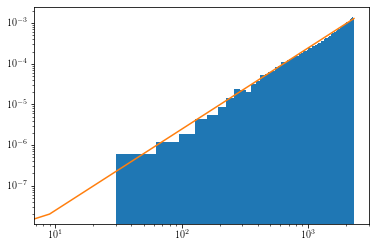

In [12]:
# Here we show that we have a uniform dist 
rm=2300
zm=z_at_value(cosmo.comoving_distance,rm*u.Mpc)
zlis=np.linspace(0,zm,300)
xlis=cosmo.comoving_distance(zlis)
ylis=4*np.pi*cosmo.comoving_distance(zlis)**2/cosmo.comoving_volume(zm)

# plt.hist(QO_dsit2[QO_dsit2<rm],bins=50)
plt.hist(QO_dsit[QO_dsit<rm],bins=70,density=1)

plt.plot(xlis,3*xlis**2/rm**3)
plt.yscale('log')
plt.xscale('log')
# plt.plot(xlis,3*ylis2)
plt.show()

In [21]:
len(QSO_car[QO_dsit<2300]), vol_1(2300)/10**10,(vol_1(2300)/(vol_1(1)*len(QSO_car[QO_dsit<2300])))**(1/3)

(50632, 5.0965010421636014, 62.17075504789603)

In [13]:
m_min=8
m_max=12
z_max=2.5
z_min=0.4

inds=(mass<m_max) & (mass>m_min) & (z < z_max) & (z > z_min) & (QO_dsit<2300)

# restricted arrays
z_new=z[inds]
dec_new=dec[inds]
ra_new=ra[inds]
mass_new=mass[inds]
dmass_new=dmass[inds]
QO_new=QO_dsit[inds]

QSO_car_new=QSO_car[inds]


DC_new=cosmo.comoving_distance(z_new)
DA_new=cosmo.angular_diameter_distance(z_new)

QO_dsit=(cdist(obs_ball,QSO_car_new).flatten())
QQ_dsit=cdist(QSO_car_new,QSO_car_new)

In [55]:
z_at_value(cosmo.comoving_volume,np.mean(cosmo.comoving_volume(z_new)))

1.363165503910485

### Functions and constants

In [14]:
theta_BH_const=(5*const.G*const.M_sun*u.rad/(const.c)**2).to(u.microarcsecond*u.Mpc)
def theta_BH(logM,DA):
    return theta_BH_const*10**logM/DA


# M_sig relation from Ho & Kormendy 2013 in units of km/sec
def MBH_to_sig(logM):
    return (10**(logM-9)/0.31)**(1/4.38)*200

grav_BH_const=(const.G*const.M_sun*u.rad/(u.km/u.s)**2).to(u.arcsecond*u.Mpc)
def grav_BH(logM,DA):
    return grav_BH_const*10**logM/DA/(MBH_to_sig(logM))**2

#Co-moving to Angular Diameter distance
cmd_to_add=int1d(logspace(-2,4.1,200),cosmo.angular_diameter_distance(np.array([z_at_value(cosmo.comoving_distance,x*u.Mpc) for x in logspace(-2,4.1,200)])).value)

In [15]:
lis=np.linspace(0,4,1000)
DA_max=np.max(cosmo.angular_diameter_distance(lis)).value #Mpc
lis=lis[:np.argmax(cosmo.angular_diameter_distance(lis))]
DAt_lis=cosmo.angular_diameter_distance(lis).value
DCt_lis=cosmo.comoving_distance(lis)
DCt_lis=np.append(DCt_lis,cosmo.comoving_distance(lis[-1])).value
DAt_lis=np.append(DAt_lis,DA_max)
add_to_cmd=int1d(DAt_lis,DCt_lis)


In [267]:
#Calculate the mean number of BH seen in a mass bin for different max distance 
mass_logs=np.linspace(8,10.5,20)
robs=1000
r1=400
r2=700
r3=1300

volvol=vol_1(robs)
Nmassr1=np.zeros(len(mass_logs))
Smassr1=np.zeros(len(mass_logs))
Nmassr2=np.zeros(len(mass_logs))
Smassr2=np.zeros(len(mass_logs))
Nmassr3=np.zeros(len(mass_logs))
Smassr3=np.zeros(len(mass_logs))
    

    
for i,x in enumerate(tqdm(mass_logs[:-1])):
    indst=(QO_new<robs+r1) & (mass_new>x) & (mass_new<mass_logs[i+1])
    QOt=QO_new[indst]
    QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
    
    a3t,a2t=co_vol_23(robs,0*QOt+r1,QOt,QQt)
    Nmassr1[i],Smassr1[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
    
    
    indst=(QO_new<robs+r2) & (mass_new>x) & (mass_new<mass_logs[i+1])
    QOt=QO_new[indst]
    QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
    
    a3t,a2t=co_vol_23(robs,0*QOt+r2,QOt,QQt)
    Nmassr2[i],Smassr2[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)
    
    
    indst=(QO_new<robs+r3) & (mass_new>x) & (mass_new<mass_logs[i+1])
    QOt=QO_new[indst]
    QQt=cdist(QSO_car_new[indst],QSO_car_new[indst])
    
    
    a3t,a2t=co_vol_23(robs,0*QOt+r3,QOt,QQt)
    Nmassr3[i],Smassr3[i]=np.sum(a2t)/volvol,np.sqrt(2*np.sum(a3t)/volvol+np.sum(a2t)/volvol-(np.sum(a2t)/volvol)**2)

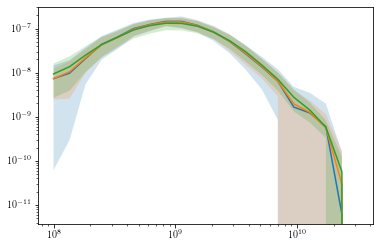

In [268]:
# Here we show that basically all distances gives the same QSO-MF

plt.loglog(10**mass_logs,Nmassr1/vol_1(r1))
plt.fill_between(10**mass_logs,(Nmassr1+Smassr1)/vol_1(r1),(Nmassr1-Smassr1)/vol_1(r1),alpha=0.2)

plt.loglog(10**mass_logs,Nmassr2/vol_1(r2))
plt.fill_between(10**mass_logs,(Nmassr2+Smassr2)/vol_1(r2),(Nmassr2-Smassr2)/vol_1(r2),alpha=0.2)

plt.loglog(10**mass_logs,Nmassr3/vol_1(r3))
plt.fill_between(10**mass_logs,(Nmassr3+Smassr3)/vol_1(r3),(Nmassr3-Smassr3)/vol_1(r3),alpha=0.2)


plt.show()

In [269]:
# Find R_i for a given mass

# Fake D_A*theta[muas] list (i.e. it may be larger than D_A max)
 
def Ri_theta(theta,Rmax,fDA):
    DA_temp=fDA/theta # divide by theta to get the fake DA
    bol_temp=DA_temp>=DA_max # where is it larger than DA_max?
    DA_temp[bol_temp]=np.full(np.sum(bol_temp),DA_max) # replace the ones larger than DA_max by DA_max
    DC_temp=add_to_cmd(DA_temp) # convert DA-->DC
    bol_temp=DC_temp>Rmax # find which ones are larger than Rmax
    DC_temp[bol_temp]=np.full(np.sum(bol_temp),Rmax) # replace the ones larger than R_max by R_max
    return DC_temp

In [270]:
#mass function +- std
n3=Nmassr3/vol_1(r3)/(np.diff(mass_logs)[0])
dn3=(Smassr3)/vol_1(r3)/(np.diff(mass_logs)[0])
n3p=(Nmassr3+Smassr3)/vol_1(r3)/(np.diff(mass_logs)[0])
n3m=(Nmassr3-Smassr3)/vol_1(r3)/(np.diff(mass_logs)[0])

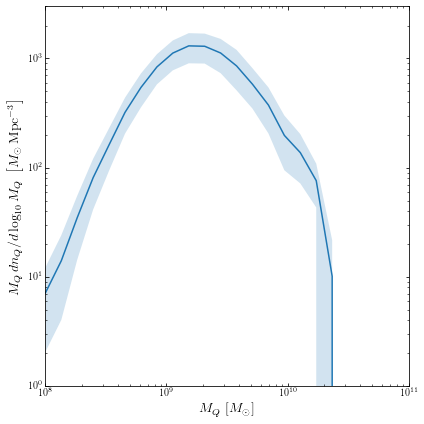

In [271]:
fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)

ax.loglog(10**mass_logs,10**mass_logs*n3)
ax.fill_between(10**mass_logs,10**mass_logs*(n3+dn3),10**mass_logs*(n3-dn3), alpha=0.2)

# plt.xlim(.01,4)
# plt.ylim(.001,3*10**3)

plt.ylabel(r'${M_Q\,dn_{ Q}/d\log_{10} M_Q}\;\left[M_\odot\,\rm Mpc^{-3}\right]$', fontsize=14)
plt.xlabel(r'$M_{ Q}\,\left[M_\odot\right]$', fontsize=14)




ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

# ax.legend(loc='upper right',fontsize=10) 
plt.xlim(10**8,10**11)
plt.ylim(1,3*10**3)

plt.savefig('../figs/Q_MF.pdf')

plt.show()

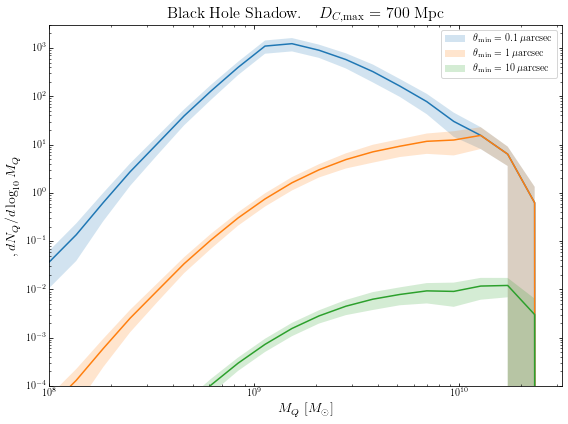

In [272]:
# shadow
fake_DA_theta=theta_BH(mass_logs,u.Mpc)/u.microarcsecond
vol_m_300=vol_1(Ri_theta(1,300,fake_DA_theta))
vol_m_700=vol_1(Ri_theta(1,700,fake_DA_theta))
vol_m_1000=vol_1(Ri_theta(1,1000,fake_DA_theta))

vol_m_p1=vol_1(Ri_theta(0.1,700,fake_DA_theta))
vol_m_1=vol_1(Ri_theta(1,700,fake_DA_theta))
vol_m_10=vol_1(Ri_theta(10,700,fake_DA_theta))

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

# ax.loglog(10**mass_logs,vol_m_1000*n3,ls='--')
# plt.fill_between(10**mass_logs,vol_m_1000*n3p,vol_m_1000*n3m,alpha=0)
# ax.loglog(10**mass_logs,vol_m_300*n3,ls=':')
# plt.fill_between(10**mass_logs,vol_m_300*n3p,vol_m_300*n3m,alpha=0)




ax.loglog(10**mass_logs,vol_m_p1*n3)
plt.fill_between(10**mass_logs,vol_m_p1*n3p,vol_m_p1*n3m,alpha=0.2
                 ,label=r'$\theta_{\rm min}=0.1\;\mu\rm arcsec$')

ax.loglog(10**mass_logs,vol_m_700*n3)
plt.fill_between(10**mass_logs,vol_m_700*n3p,vol_m_1*n3m,alpha=0.2
                ,label=r'$\theta_{\rm min}=1\;\mu\rm arcsec$')

plt.loglog(10**mass_logs,vol_m_10*n3)
plt.fill_between(10**mass_logs,vol_m_10*n3p,vol_m_10*n3m,alpha=0.2
                ,label=r'$\theta_{\rm min}=10\;\mu\rm arcsec$')


plt.xlim(10**8,10**10.5)
plt.ylim(.0001,3*10**3)

ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.title(r'${\rm Black\;Hole\;Shadow.}\;\;\;\;D_{C,\rm max}=700\;\rm{Mpc}$', fontsize=16)
#plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)
plt.ylabel(r'${,dN_Q/d\log_{10} M_Q}$', fontsize=14)
plt.xlabel(r'$M_Q\,\left[M_\odot\right]$', fontsize=14)

plt.savefig('../figs/shad_MF.pdf')

plt.show()

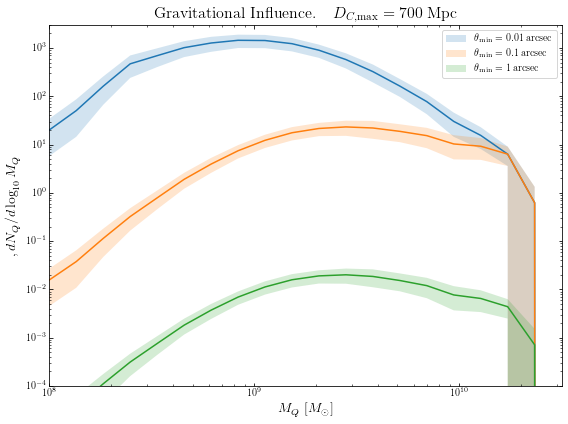

In [273]:
# grav
fake_DA_g=grav_BH(mass_logs,u.Mpc)/u.arcsec
vol_m_300=vol_1(Ri_theta(1,300,fake_DA_g))
vol_m_700=vol_1(Ri_theta(1,700,fake_DA_g))
vol_m_1000=vol_1(Ri_theta(1,1000,fake_DA_g))

vol_m_pp1=vol_1(Ri_theta(0.01,700,fake_DA_g))
vol_m_p1=vol_1(Ri_theta(0.1,700,fake_DA_g))
vol_m_1=vol_1(Ri_theta(1,700,fake_DA_g))
# vol_m_10=vol_1(Ri_theta(10,700,fake_DA_g))

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

# ax.loglog(10**mass_logs,vol_m_1000*n3,ls='--')
# plt.fill_between(10**mass_logs,vol_m_1000*n3p,vol_m_1000*n3m,alpha=0)
# ax.loglog(10**mass_logs,vol_m_300*n3,ls=':')
# plt.fill_between(10**mass_logs,vol_m_300*n3p,vol_m_300*n3m,alpha=0)


ax.loglog(10**mass_logs,vol_m_pp1*n3)
plt.fill_between(10**mass_logs,vol_m_pp1*n3p,vol_m_pp1*n3m,alpha=0.2
                 ,label=r'$\theta_{\rm min}=0.01\;\rm arcsec$')

ax.loglog(10**mass_logs,vol_m_p1*n3)
plt.fill_between(10**mass_logs,vol_m_p1*n3p,vol_m_p1*n3m,alpha=0.2
                 ,label=r'$\theta_{\rm min}=0.1\;\rm arcsec$')

ax.loglog(10**mass_logs,vol_m_700*n3)
plt.fill_between(10**mass_logs,vol_m_700*n3p,vol_m_1*n3m,alpha=0.2
                ,label=r'$\theta_{\rm min}=1\;\rm arcsec$')



plt.xlim(10**8,10**10.5)
plt.ylim(.0001,3*10**3)

ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;D_{C,\rm max}=700\;\rm{Mpc}$', fontsize=16)
#plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)
plt.ylabel(r'${,dN_Q/d\log_{10} M_Q}$', fontsize=14)
plt.xlabel(r'$M_Q\,\left[M_\odot\right]$', fontsize=14)

plt.savefig('../figs/grav_MF.pdf')

plt.show()

In [274]:
# min mass for a given theta
z_rmax=z_at_value(cosmo.comoving_distance,r3*u.Mpc)
zran=np.logspace(-4,np.log10(z_rmax),300)

DC_ran=cosmo.comoving_distance(zran).value



def mmin_z(theta):
    return theta*u.microarcsecond/theta_BH(0,cosmo.angular_diameter_distance(zran))

def mmin_g_z(theta):
    return (theta*u.arcsecond/grav_BH(0,cosmo.angular_diameter_distance(zran)))**(1/0.543379)#power-law from the M-sig relation


In [275]:
#Shadow
# Number per comoving dist
def dN_shad_dDC(q):
    thing=np.array([
        4*np.pi*DC_ran[i]**2*np.trapz(n3[mass_logs>x],mass_logs[mass_logs>x]) 
        for i,x in enumerate(np.log10(mmin_z(q).value))
    ])
    return thing
#and the error
def ddN_shad_dDC(q):
    thing=np.array([
        4*np.pi*DC_ran[i]**2*np.trapz(dn3[mass_logs>x],mass_logs[mass_logs>x]) 
        for i,x in enumerate(np.log10(mmin_z(q).value))
    ])
    return thing+dN_shad_dDC(q),-thing+dN_shad_dDC(q)


# total for theta min and DC max
theta_logs=np.logspace(-2,2,100)

def N_shad_q(DCmax):
    thing=np.array([
        np.trapz(dN_shad_dDC(q)[DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_logs
    ])
    return thing
# and error
def dN_shad_q(DCmax):
    thing0=np.array([
        np.trapz(ddN_shad_dDC(q)[0][DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_logs
    ])
    thing1=np.array([
        np.trapz(ddN_shad_dDC(q)[1][DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_logs
    ])
    return thing0, thing1




# gravity
def dN_grav_dDC(q):
    thing=np.array([
        4*np.pi*DC_ran[i]**2*np.trapz(n3[mass_logs>x],mass_logs[mass_logs>x]) 
        for i,x in enumerate(np.log10(mmin_g_z(q).value))
    ])
    return thing

def ddN_grav_dDC(q):
    thing=np.array([
        4*np.pi*DC_ran[i]**2*np.trapz(dn3[mass_logs>x],mass_logs[mass_logs>x]) 
        for i,x in enumerate(np.log10(mmin_g_z(q).value))
    ])
    return thing+dN_grav_dDC(q),-thing+dN_grav_dDC(q)



theta_g_logs=np.logspace(-3,1,100)

def N_grav_q(DCmax):
    thing=np.array([
        np.trapz(dN_grav_dDC(q)[DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_g_logs
    ])
    return thing

def dN_grav_q(DCmax):
    thing0=np.array([
        np.trapz(ddN_grav_dDC(q)[0][DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_g_logs
    ])
    thing1=np.array([
        np.trapz(ddN_grav_dDC(q)[1][DC_ran<=DCmax*1.001],DC_ran[DC_ran<=DCmax*1.001])
        for q in theta_g_logs
    ])
    return thing0, thing1


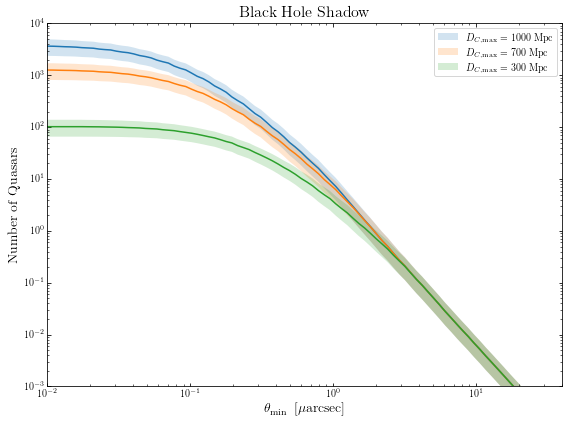

In [276]:
# Shadow


fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

plt.loglog(theta_logs,N_shad_q(1000))
plt.fill_between(theta_logs,*dN_shad_q(1000),alpha=0.2,
                label=r'$D_{C,\rm max}=1000\;\rm Mpc$')

plt.loglog(theta_logs,N_shad_q(700))
plt.fill_between(theta_logs,*dN_shad_q(700),alpha=0.2,
                label=r'$D_{C,\rm max}=700\;\rm Mpc$')

plt.loglog(theta_logs,N_shad_q(300))
plt.fill_between(theta_logs,*dN_shad_q(300),alpha=0.2,
                label=r'$D_{C,\rm max}=300\;\rm Mpc$')



plt.xlim(10**(-2),40)
plt.ylim(.001,10**4)

ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.title(r'${\rm Black\;Hole\;Shadow}$', fontsize=16)
#plt.title(r'${\rm Gravitational\;Influence.}\;\;\;\;10^8\;M_\odot<M_{\rm QSO}$', fontsize=16)
plt.ylabel(r'${\rm Number\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[\mu \rm arcsec\right]$', fontsize=14)

plt.savefig('../figs/shad_TOT.pdf')

plt.show()

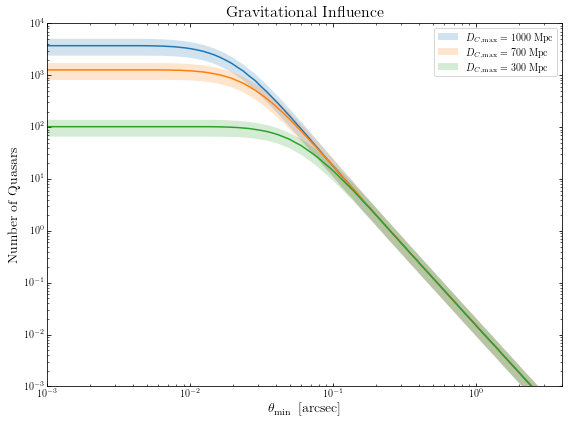

In [277]:
# grav


fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

plt.loglog(theta_g_logs,N_grav_q(1000))
plt.fill_between(theta_g_logs,*dN_grav_q(1000),alpha=0.2,
                label=r'$D_{C,\rm max}=1000\;\rm Mpc$')

plt.loglog(theta_g_logs,N_grav_q(700))
plt.fill_between(theta_g_logs,*dN_grav_q(700),alpha=0.2,
                label=r'$D_{C,\rm max}=700\;\rm Mpc$')

plt.loglog(theta_g_logs,N_grav_q(300))
plt.fill_between(theta_g_logs,*dN_grav_q(300),alpha=0.2,
                label=r'$D_{C,\rm max}=300\;\rm Mpc$')



plt.xlim(10**(-3),4)
plt.ylim(.001,10**4)

ax.legend(loc='upper right',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

# plt.title(r'${\rm Black\;Hole\;gravow}$', fontsize=16)
plt.title(r'${\rm Gravitational\;Influence}$', fontsize=16)
plt.ylabel(r'${\rm Number\;of\;Quasars}$', fontsize=14)
plt.xlabel(r'$\theta_{\rm min}\;\left[ \rm arcsec\right]$', fontsize=14)

plt.savefig('../figs/grav_TOT.pdf')

plt.show()

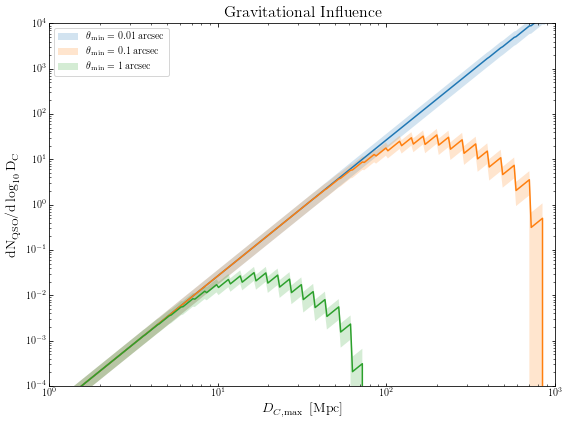

In [278]:
to_dlog=np.log(10)*DC_ran

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(DC_ran,to_dlog*dN_grav_dDC(0.01))
ax.fill_between(DC_ran,*to_dlog*ddN_grav_dDC(0.01), alpha=0.2,
                label=r'$\theta_{\rm min}=0.01\;{\rm arcsec}$')

ax.loglog(DC_ran,to_dlog*dN_grav_dDC(0.1))
ax.fill_between(DC_ran,*to_dlog*ddN_grav_dDC(0.1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;{\rm arcsec}$')

ax.loglog(DC_ran,to_dlog*dN_grav_dDC(1))
ax.fill_between(DC_ran,*to_dlog*ddN_grav_dDC(1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;{\rm arcsec}$')


plt.xlim(1,1000)
plt.ylim(10**(-4),10**4)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}D_C}$', fontsize=14)
plt.xlabel(r'$D_{C,\rm{max}}\;\left[\rm{Mpc}\right]$', fontsize=14)
plt.title(r'${\rm Gravitational\;Influence}$', fontsize=16)

ax.legend(loc='upper left',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/grav_dNdD.pdf')


plt.show()

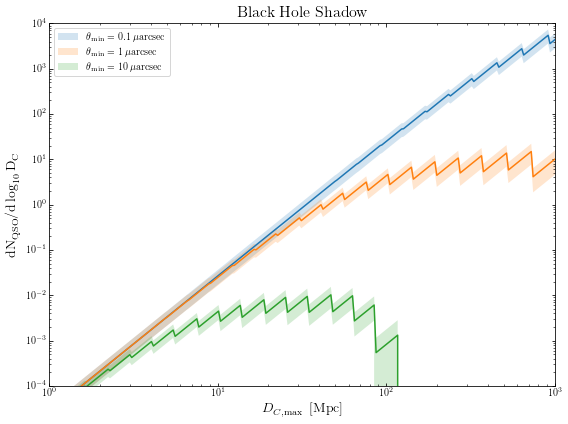

In [279]:
to_dlog=np.log(10)*DC_ran

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)

ax.loglog(DC_ran,to_dlog*dN_shad_dDC(0.1))
ax.fill_between(DC_ran,*to_dlog*ddN_shad_dDC(0.1), alpha=0.2,
                label=r'$\theta_{\rm min}=0.1\;{\mu\rm arcsec}$')

ax.loglog(DC_ran,to_dlog*dN_shad_dDC(1))
ax.fill_between(DC_ran,*to_dlog*ddN_shad_dDC(1), alpha=0.2,
                label=r'$\theta_{\rm min}=1\;{\mu\rm arcsec}$')

ax.loglog(DC_ran,to_dlog*dN_shad_dDC(10))
ax.fill_between(DC_ran,*to_dlog*ddN_shad_dDC(10), alpha=0.2,
                label=r'$\theta_{\rm min}=10\;{\mu\rm arcsec}$')


plt.xlim(1,1000)
plt.ylim(10**(-4),10**4)

plt.ylabel(r'$\rm{dN_{QSO}/d\log_{10}D_C}$', fontsize=14)
plt.xlabel(r'$D_{C,\rm{max}}\;\left[\rm{Mpc}\right]$', fontsize=14)

plt.title(r'${\rm Black\;Hole\;Shadow}$', fontsize=16)

ax.legend(loc='upper left',fontsize=10) 

ax.tick_params(axis='both', which='both', direction='in', top=True,right=True)

plt.savefig('../figs/shad_dNdD.pdf')


plt.show()